In [1]:
# !pip install sklearn
# !pip3 install osqp==0.6.1
# !pip3 install fancyimpute
# !pip install missingpy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv('processed/df.csv')
df_numeric = pd.read_csv('processed/df_numeric.csv')
numerical_columns = [line.strip() for line in open('processed/numerical_columns.txt', 'r')]
categorical_columns = [line.strip() for line in open('processed/categorical_columns.txt', 'r')]

## Identification of missing data

In [4]:

def print_range_of_values(dataframe):
    for col in dataframe.columns:
        print(col, '\t',dataframe[col].unique())
        
print_range_of_values(df[categorical_columns])


specific_gravity 	 ['_1.020' '_1.010' '_1.005' '_1.015' nan '_1.025']
albumin 	 ['_1' '_4' '_2' '_3' '_0' nan '_5']
sugar 	 ['_0' '_3' '_4' '_1' nan '_2' '_5']
red_blood_cells 	 [nan 'normal' 'abnormal']
pus_cell 	 ['normal' 'abnormal' nan]
pus_cell_clumps 	 ['notpresent' 'present' nan]
bacteria 	 ['notpresent' 'present' nan]
hypertension 	 [True False nan]
diabetes_mellitus 	 [True False nan]
coronary_artery_disease 	 [False True nan]
appetite 	 ['good' 'poor' nan]
pedal_edema 	 [False True nan]
anemia 	 [False True nan]
class 	 [ True False]


In [5]:
def get_nr_none(dataframe):
    cols = []
    for col in dataframe.columns:
        total = len(df)
        none = np.count_nonzero(dataframe[col].isnull().values)
        ratio = none/total
        cols.append((col, total, none, ratio))
    return sorted(cols, key=lambda tup: tup[3], reverse=True)

def print_nr_none(dataframe):
    nr_none = get_nr_none(dataframe)
    print('column \t total \t none \t ratio')
    for col, total, none, ratio in nr_none:
        print(col, '\t', total, '\t', none, '\t', ratio)

In [6]:
print_nr_none(df)

column 	 total 	 none 	 ratio
red_blood_cells 	 349 	 149 	 0.4269340974212034
red_blood_cell_count 	 349 	 131 	 0.3753581661891118
white_blood_cell_count 	 349 	 106 	 0.3037249283667622
potassium 	 349 	 87 	 0.2492836676217765
sodium 	 349 	 86 	 0.24641833810888253
packed_cell_volume 	 349 	 70 	 0.20057306590257878
pus_cell 	 349 	 62 	 0.17765042979942694
hemoglobin 	 349 	 51 	 0.14613180515759314
sugar 	 349 	 49 	 0.14040114613180515
specific_gravity 	 349 	 47 	 0.1346704871060172
albumin 	 349 	 46 	 0.1318051575931232
blood_glucose_random 	 349 	 43 	 0.12320916905444126
blood_urea 	 349 	 18 	 0.05157593123209169
serum_creatinine 	 349 	 17 	 0.04871060171919771
blood_pressure 	 349 	 12 	 0.034383954154727794
age 	 349 	 9 	 0.025787965616045846
pus_cell_clumps 	 349 	 4 	 0.011461318051575931
bacteria 	 349 	 4 	 0.011461318051575931
hypertension 	 349 	 2 	 0.0057306590257879654
diabetes_mellitus 	 349 	 2 	 0.0057306590257879654
coronary_artery_disease 	 349 	 2 	 0.0

#### Summary
- rbc (red blood cells [normal / abnormal]) has a missing value ratio of 43%
- rbcc (red blood cell count (numerical)) has a missing value ratio of 38%
- wbcc (white blood cell count) has a missing value ratio of 30%
- pot, sod, pcv have missing value ratios between 20% and 25%
- pc, hemo, su, sg, al, bgr have missing value ratios between 10% and 20%
- the rest have a missing value ratio of less than 6%.  

### Evaluating the dataset without missing values

In [7]:
df_without_nan = df.dropna()
df_without_nan.describe()


,age,blood_pressure,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,hemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count
count,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000,113.000000
mean,49.575221,75.044248,143.070796,60.168142,2.727434,137.566372,4.808850,13.032743,39.477876,8815.044248,4.691150
std,14.444973,11.886659,72.668243,53.657130,3.496152,8.096379,4.083537,3.082046,9.385682,3470.313418,1.080555
min,6.000000,50.000000,70.000000,10.000000,0.500000,111.000000,2.500000,3.100000,9.000000,3800.000000,2.100000
25%,41.000000,70.000000,100.000000,29.000000,0.800000,135.000000,3.800000,10.500000,32.000000,6700.000000,3.900000
50%,50.000000,80.000000,122.000000,40.000000,1.200000,138.000000,4.600000,13.800000,42.000000,8100.000000,4.800000
75%,60.000000,80.000000,137.000000,60.000000,3.200000,143.000000,4.900000,15.400000,46.000000,10200.000000,5.500000
max,83.000000,110.000000,490.000000,309.000000,15.200000,150.000000,47.000000,17.800000,52.000000,26400.000000,8.000000


From a total of 400 rows, 158 rows have no missing values. A lot of statistical power gets lost if all the nan values are dropped.

### No columns are dropped

As we have found out in the exploratory data analysis, all of our columns except potassium have a some correlation with the class variable. Potassium could be dropped but since 

## Potential columns for removal

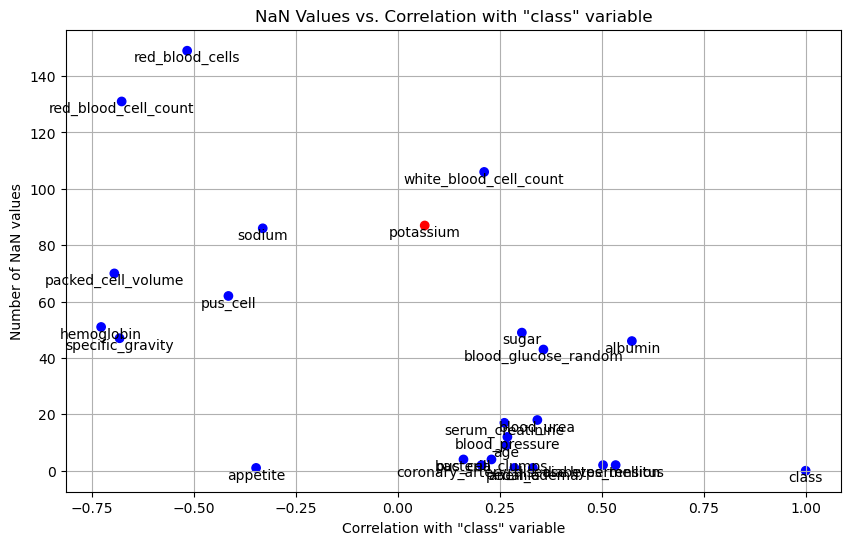

In [8]:
nan_counts = df.isna().sum().sort_values(ascending = False)
# Retrieve correlation values with the 'class' variable
correlation_values = df_numeric.corr()['class']

# Merge correlation values and NaN counts into a single DataFrame
correl_nan = pd.concat([correlation_values, nan_counts], axis=1, keys=['Correlation', 'NaN_Count'])

colors = np.where(np.abs(correl_nan['Correlation']) < 0.1, 'red', 'blue')

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(correl_nan['Correlation'], correl_nan['NaN_Count'],  c=colors)
plt.xlabel('Correlation with "class" variable')
plt.ylabel('Number of NaN values')
plt.title('NaN Values vs. Correlation with "class" variable')

for i, row in correl_nan.iterrows():
    plt.text(row['Correlation'], row['NaN_Count'], i, ha='center', va='top')


plt.grid(True)
plt.show()

### Results

The potassium column could be dropped since its correlation with the class is very low (below 0.1). But there are other columns which have much more nan values and have a negative correlation with the class variables. We choose to impute the values instead of dropping any columns.

## Identification of the missing data mechanisms

### Correlations between the missingness of some columns and other available values

In [9]:
import seaborn as sns
for col in df_numeric.columns:
    df_to_check = df_numeric.copy()
    df_to_check[col] = df_to_check[col].isna()
    correlation_matrix = pd.DataFrame(df_to_check.corr().abs()[col].sort_values(ascending=False)).where(lambda x: x > 0.3).dropna()
    if(len(correlation_matrix) > 1):
        print('-----------------')
        print('missing values in', col)
        print(correlation_matrix)
        print()


-----------------
missing values in red_blood_cells
                 red_blood_cells
red_blood_cells         1.000000
class                   0.466053

-----------------
missing values in sodium
          sodium
sodium  1.000000
class   0.300845

-----------------
missing values in potassium
           potassium
potassium   1.000000
sodium      0.744785
class       0.303850

-----------------
missing values in white_blood_cell_count
                        white_blood_cell_count
white_blood_cell_count                1.000000
class                                 0.318864

-----------------
missing values in red_blood_cell_count
                      red_blood_cell_count
red_blood_cell_count              1.000000
class                             0.395924



### Correlations between the missingness of one columns and the missingness of another

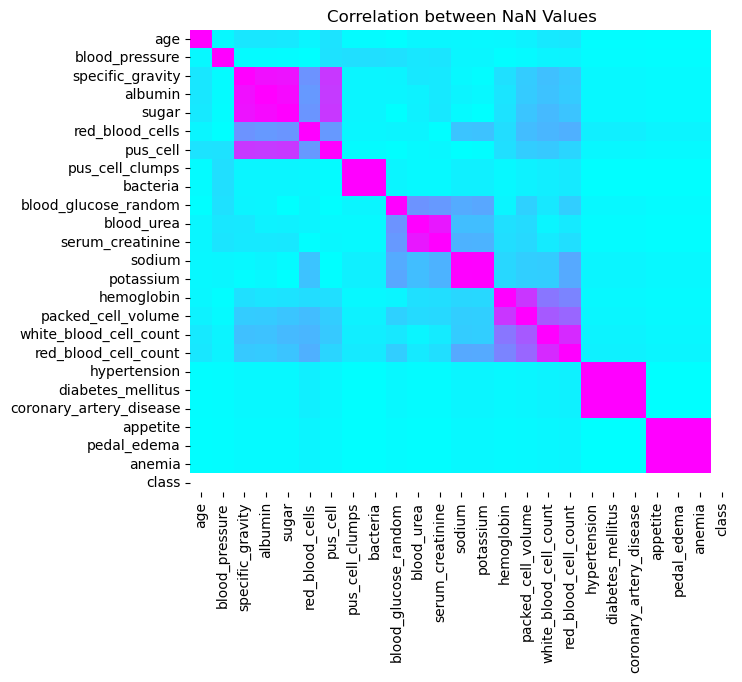

In [10]:
import seaborn as sns
plt.figure(figsize=(7, 6))
nan_corr = df_numeric.isna().corr().abs()
sns.heatmap(nan_corr, cbar=False,  cmap='cool',)
plt.title('Correlation between NaN Values')
plt.show()


### Results: MAR or MNAR

The fact that the missingness of some variables is correlated to the missingness of other variables, combined with the fact that the missingness of some variables has a correlation with other non-nan variables that is greater than 0.2, suggests that the missingness is not completely random. 

In order to find out whether the data is MNAR, we would need to investigate the source of the data and the data collection process. Since that is not feasible in the scope of this project, we will assume that the data is MAR. 

In case the missing data is in fact MNAR, the imputation methods used in this project will be biased.

# Imputation


## Approach

Since there are so many missing data points in our dataset, we will try to find the optimal imputation method throughout our analysis. In order to be able to compare different imputation methods for the same data prediction method, we will split the dataset into a training and a test set before imputation, training and evaluation.

## Results

In [11]:

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from fancyimpute import IterativeImputer as MICE
from sklearn.metrics import confusion_matrix, classification_report


# Select columns with numerical data

imputation_methods = {
    'mean': SimpleImputer(strategy='mean'),
    'median': SimpleImputer(strategy='median'),
    'mode': SimpleImputer(strategy='most_frequent'),
    'KNN': KNNImputer(n_neighbors=2),
    'MICE': MICE(),
    'iterative': IterativeImputer(random_state=0),
}
dataframes = {
    'mean': df_numeric.copy(), 
    'median': df_numeric.copy(), 
    'mode': df_numeric.copy(), 
    'KNN': df_numeric.copy(), 
    'MICE': df_numeric.copy(), 
    'iterative': df_numeric.copy()
}




In [12]:
def visualize_imputation(dataframes):
    columns = df_numeric.columns

    # Calculate the number of rows and columns for the subplots
    num_plots = len(columns)
    num_rows = 15  # Adjust the number of rows as desired
    num_cols = int(np.ceil(num_plots / num_rows))

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 4*num_rows))

    # Flatten the axes array
    axes = axes.flatten()

    # Iterate through the columns and create the overlay plots
    for i, col in enumerate(columns):
        ax = axes[i]  # Select the appropriate subplot

        # Plot the original values
        ax.scatter(df_numeric.index, df_numeric[col], label='Orig', color='black')
        for name, dataframe in dataframes: 
            imputed = [x if np.isnan(df_numeric[col][j]) else None for j, x in enumerate(dataframe[col]) ]
        # Plot the imputed values
            ax.scatter(dataframe.index, imputed, label=name, alpha=0.5)

        nr_imputed = len(list(filter(lambda imp: imp != None, imputed)))
        ax.set_xlabel('Index')
        ax.set_ylabel(col)
        ax.set_title(f'{col} ({nr_imputed} imputed)')
        ax.legend()

    # Remove any unused subplots
    if num_plots < len(axes):
        for ax in axes[num_plots:]:
            ax.remove()

    # Adjust the layout and spacing of subplots
    plt.tight_layout()

    # Show the plot
    plt.show()


Imputing with mean method
Imputing with median method
Imputing with mode method
Imputing with KNN method
Imputing with MICE method
Imputing with iterative method


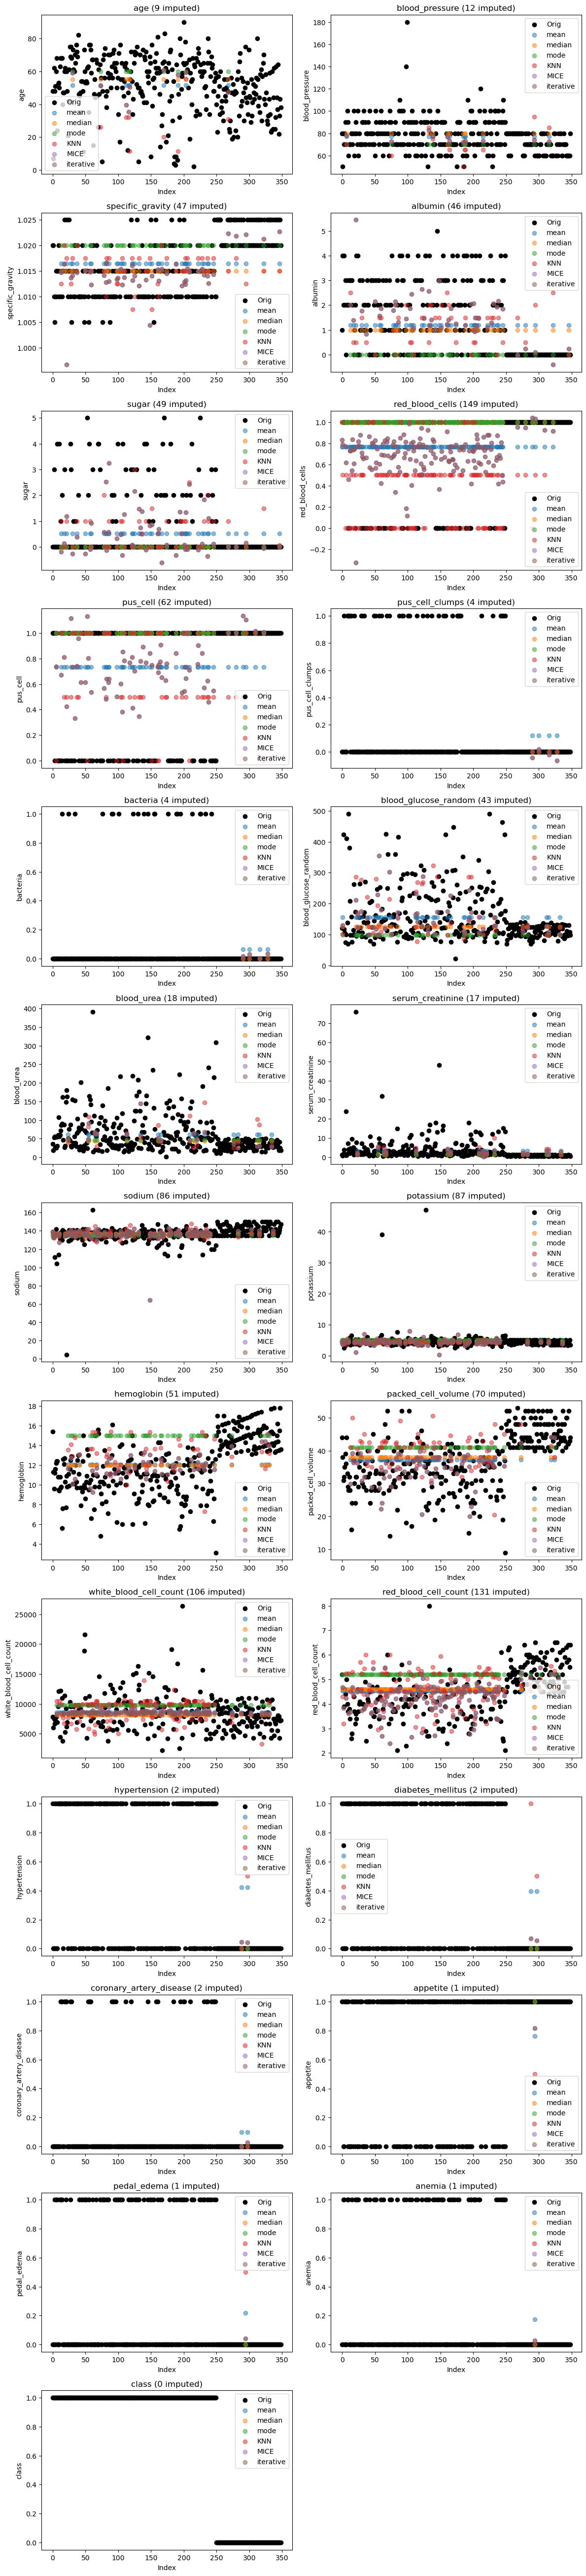

In [13]:
for impute_name, imputer in imputation_methods.items():
    print(f"Imputing with {impute_name} method")
    df_imputed = df_numeric.copy()
    df_imputed[df_numeric.columns] = imputer.fit_transform(df_numeric)
    dataframes[impute_name] = df_imputed
    # visualize_imputation([(impute_name, df_imputed)])

visualize_imputation(dataframes.items())


## Snapping the categorical values to the categories

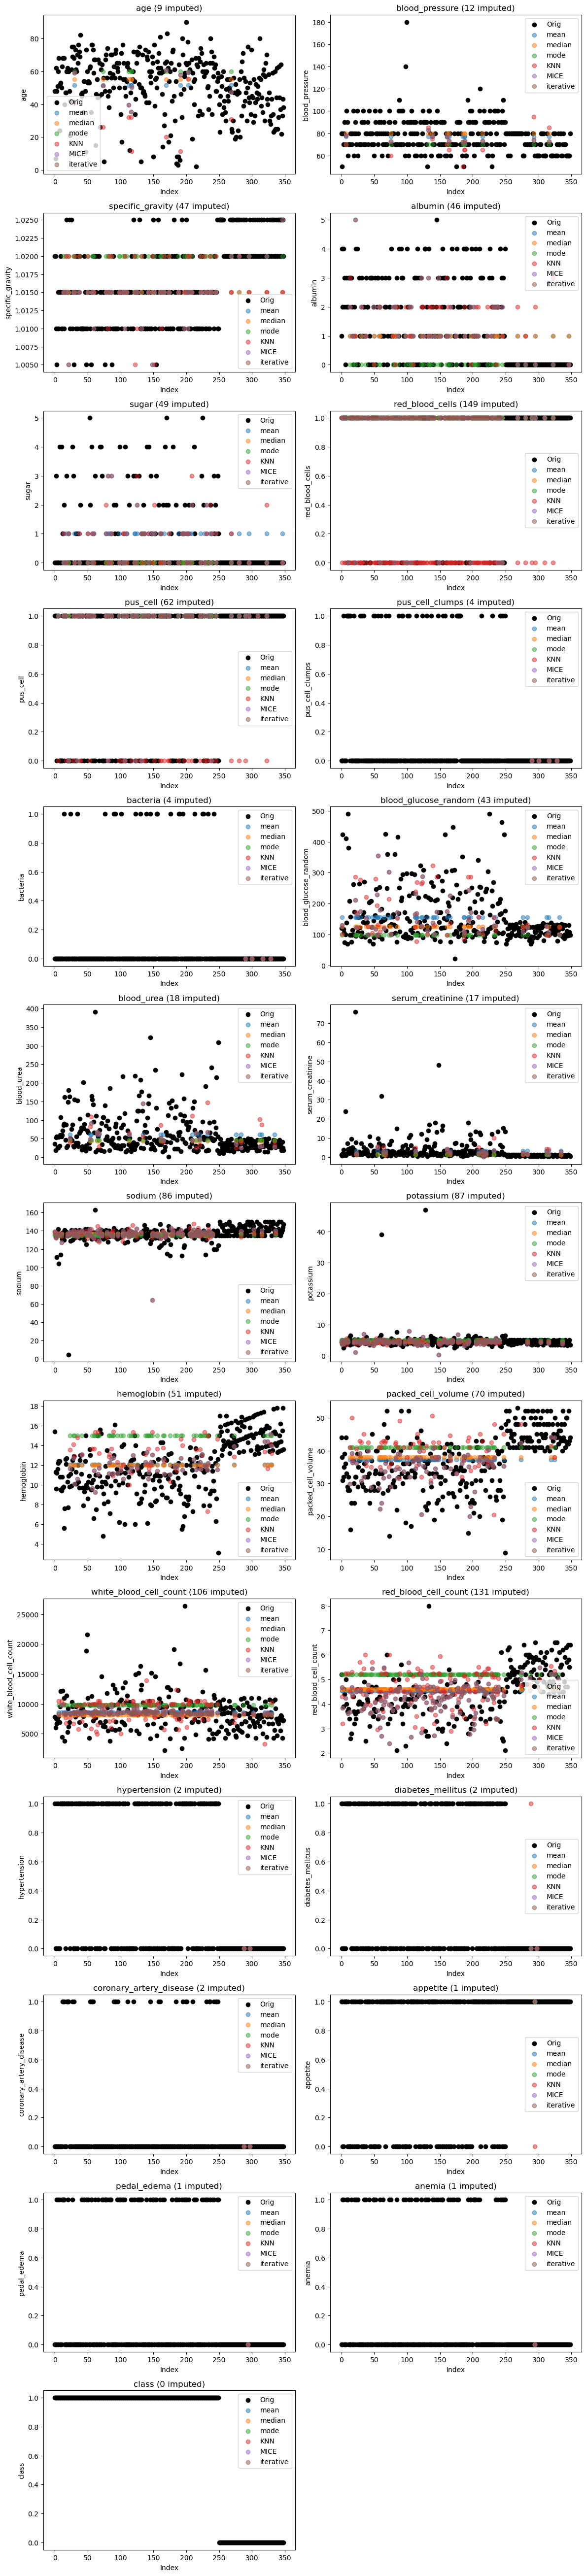

In [14]:
binary_columns = ['red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria', 'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'pedal_edema', 'anemia', ]
zero_to_five = [ 'albumin', 'sugar']
sg = ['specific_gravity']
for (name, dataframe) in dataframes.items():
    snapped_bin = dataframe[binary_columns].applymap(lambda x: 1 if x > 0.5 else 0)
    dataframe[binary_columns] = snapped_bin
    snapped_zero_to_five = dataframe[zero_to_five].applymap(lambda x: 0 if x < 0.5 else 1 if x < 1.5 else 2 if x < 2.5 else 3 if x < 3.5 else 4 if x < 4.5 else 5)
    dataframe[zero_to_five] = snapped_zero_to_five
    snapped_sg = dataframe[sg].applymap(lambda x: 1.005 if x < 1.0075 else 1.010 if x < 1.0125 else 1.015 if x < 1.0175 else 1.020 if x < 1.0225 else 1.025)
    dataframe[sg] = snapped_sg

    # visualize_imputation([(name, dataframe)])
    
visualize_imputation(dataframes.items())

    
    
    

## Comparing with original data

In [15]:
# Heatmap
# 